In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

In [2]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
start = 0
data_len = 1000 # number of time bins to use for fitting
timepoints = np.arange(start, data_len+start) #subsample ~40 seconds of data so things will run somewhat quicker
print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
# fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions

Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 8, :] #subsample highly active neurons so things will run a bit quicker
# Y_test = Y[..., 1000:] # hold out some data for testing
# Y = Y[..., :1000] # use first 1000 time bins for training
print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
delay = 120
vels = cs(ts, 1) # velocity (first derivative)


(1, 200, 70482)
(1, 102, 1000)


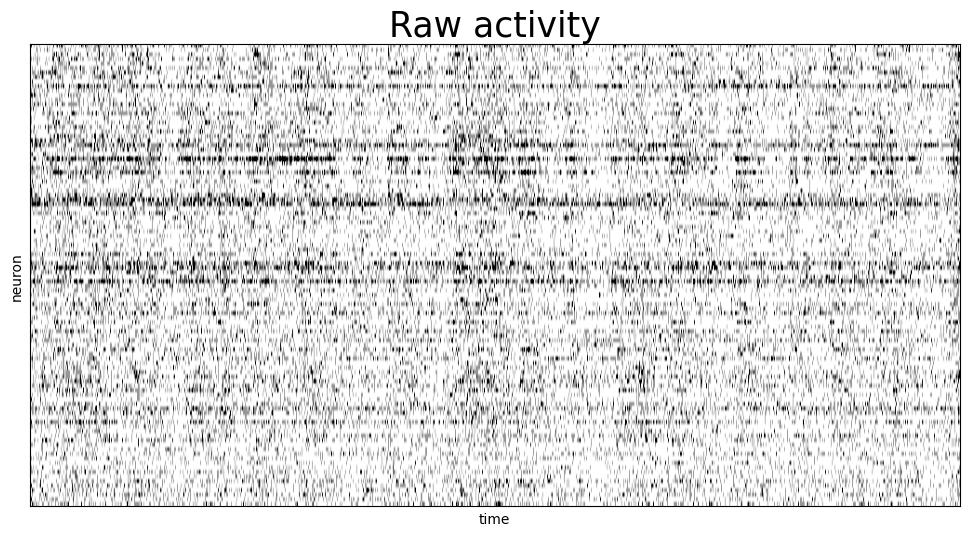

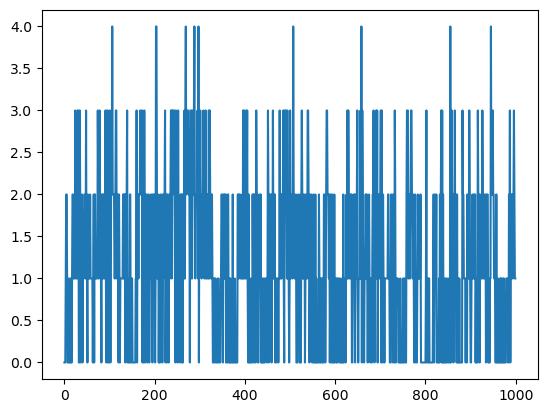

In [3]:
plt.figure(figsize = (12, 6))
plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

# Plot spikes for neuron with highest firing rate
# plt.figure(figsize = (12, 6))
plt.plot(Y[0, np.argmax(np.mean(Y, axis = -1)), :])
plt.show()

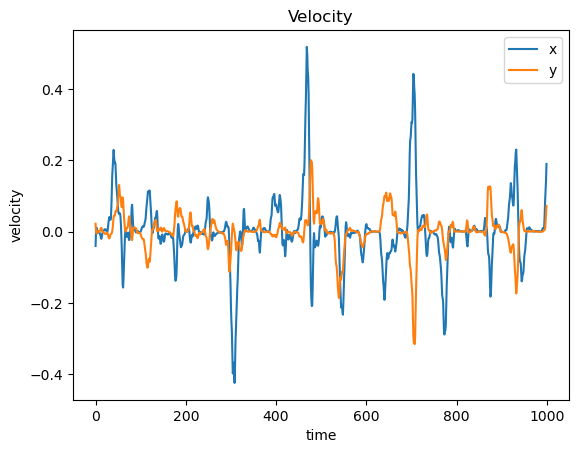

(1, 102, 1000) (1000, 2)


In [3]:
plt.plot(vels[:, 0], label = 'x')
plt.plot(vels[:, 1], label = 'y')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity', fontsize = 12)
plt.show()

print(Y.shape, vels.shape)

torch.Size([1, 10, 1000])
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
step 0 LL -0.44474909319196426
step 1 LL -0.432923828125
step 2 LL -0.42225537109375
step 3 LL -0.4124515904017857
step 4 LL -0.40339822823660715
step 5 LL -0.3951158621651786
step 6 LL -0.38754959542410716
step 7 LL -0.38069468470982143
step 8 LL -0.3745614536830357
step 9 LL -0.36906222098214286
step 10 LL -0.3641396484375
step 11 LL -0.35976681082589285
step 12 LL -0.35597042410714286
step 13 LL -0.3526289760044643
step 14 LL -0.3497177734375
step 15 LL -0.34717417689732144
step 16 LL -0.34495068359375
step 17 LL -0.34298179408482143
step 18 LL -0.3413111746651786
step 19 LL -0.3398671875
step 20 LL -0.33860281808035714
step 21 LL -0.33748235212053573
step 22 LL -0.3365311802455357
step 23 LL -0.33571128627232144
step 24 LL -0.3350224609375
step 25 LL -0.33442306082589285
step 26 LL -0.33392640904017856
step 27 LL -0.3334921875
step 28 LL -0.3331376255580357
step 29 LL -0.33284842354910715
step 30 

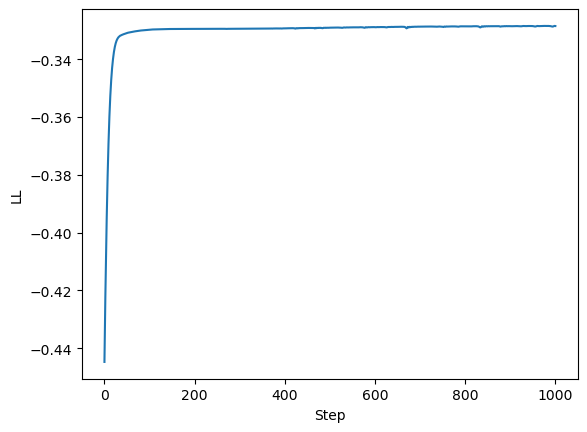

In [4]:
link_fn = torch.nn.functional.softplus
# link_fn = torch.exp
lik = Poisson_noise()

# link_fn = lambda x: x
# lik = Negative_binomial_noise(Y=Tensor(Y))

np.random.seed(0)
torch.manual_seed(0)

# train_len = 1000
# v = vels.T[None, ...]
# v_train = v[..., :train_len]
# Y_train = Y[..., :train_len]
# print(v_train.shape)
# model = LDS(Tensor(v_train), Tensor(Y_train), lik, link_fn=link_fn, fixed_d=False)
# train_params = {'batch_size': None, 'n_mc': 200, 'lrate': 1e-2}
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

suffix = '10'

# Fixed generative model
z = Tensor(np.load('z_hat' + suffix + '.npy'))[..., start:start+data_len]
print(z.shape)
A = Tensor(np.load('params/A' + suffix + '.npy'))[None, ...].to(device)
B = Tensor(np.load('params/B' + suffix + '.npy'))[None, ...].to(device)
W = np.load('params/W' + suffix + '.npy')
mu0 = Tensor(np.load('params/mu0' + suffix + '.npy'))[None, ...].to(device)
Sigma0_half = Tensor(np.load('params/Sigma0_half' + suffix + '.npy'))[None, ...].to(device)

def is_lower_triangular(tensor):
    return torch.all(tensor.triu(1) == 0)
print(is_lower_triangular(Tensor(Sigma0_half)))
print(is_lower_triangular(Tensor(B)))

# print(B - torch.linalg.cholesky(B @ B.transpose(-1,-2)))
def convert_to_trials(_Y, _v, t):
    assert _Y.shape[-1] % t == 0
    ntrials = _Y.shape[-1] // t
    Y = _Y.reshape(ntrials, -1, t)
    v = _v.reshape(ntrials, -1, t)
    return Y, v

# print(Y.shape, z.shape)
# Y_train, z_train = convert_to_trials(Y, z, 1000)
# print(Y_train.shape, z_train.shape)

train_len = 1000
Y_train = Y[..., :train_len]
z_train = z[..., :train_len]

# _W = torch.randn(1, z_train.shape[1], z_train.shape[1]).to(device) / np.sqrt(z_train.shape[1])
# _C = torch.randn(1, Y_train.shape[1], z_train.shape[1]).to(device) / np.sqrt(z_train.shape[1])

model = LDS(z_train, Tensor(Y_train), lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True, fixed_d=False, single_sigma_x=False)
# train_params = {'batch_size': 10, 'n_mc': 50, 'lrate': 5e-2, 'max_steps': 1001, 'step_size': 1000}
train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 5e-2, 'max_steps': 1001, 'step_size': 1000}
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

tensor([[  10.4177,   17.4164,   33.9276,  -16.4706,   -6.0412,  -23.8545,
           40.3060,   -2.9633,  -11.2634,   45.6243,    5.9743,   -2.8364,
           10.9743,    3.9029,   11.1469,   69.8021,   -5.0655,   -4.8847,
            5.6789,   36.8902,    6.5782,  -74.5806,    2.0606,   47.3461,
          -13.7025,  106.0228,   -9.4495,   15.6155,   84.7577,    4.0119,
            8.2035,   -1.0686,    6.9041,   31.2797,  -54.8755, -172.0874,
            0.2934,   43.9891,    6.5159,  -17.9323,   -1.4047,   -4.8471,
           -3.8584,    7.9531,    1.7867,   -9.1864,  -44.4272,   16.7725,
         -139.4890,  -52.4189,   67.4043,  -18.4994,   57.1223,  -10.4444,
           19.4842,   -2.9054,   -1.0220,   55.0521,  -26.7364,   73.2397,
           -5.0715,  -20.1712,    0.6195,   29.2798,   -2.3629,   -2.3469,
          -17.5835,   85.1738,  -36.6514,  -65.4733,   -6.1127,    0.5384,
          -26.6463,  -17.1120,   33.7226,   44.4555,   -9.6897,    1.6098,
           -4.6877,   -7.

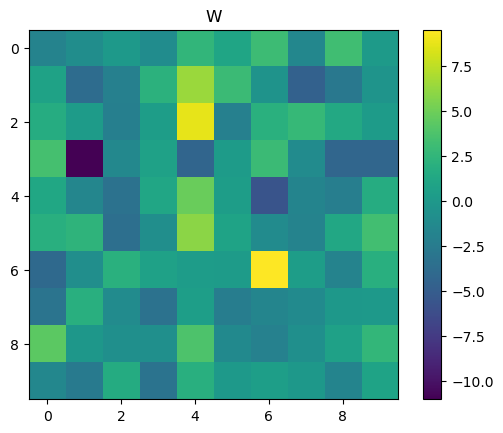

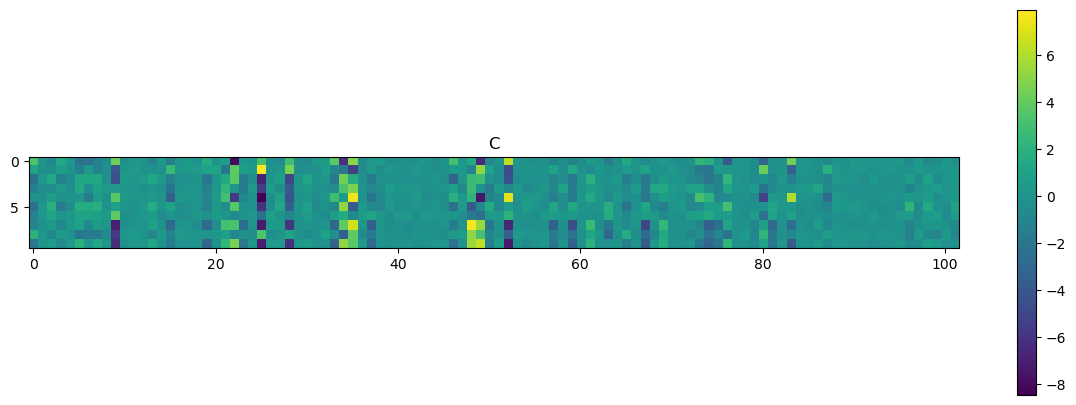

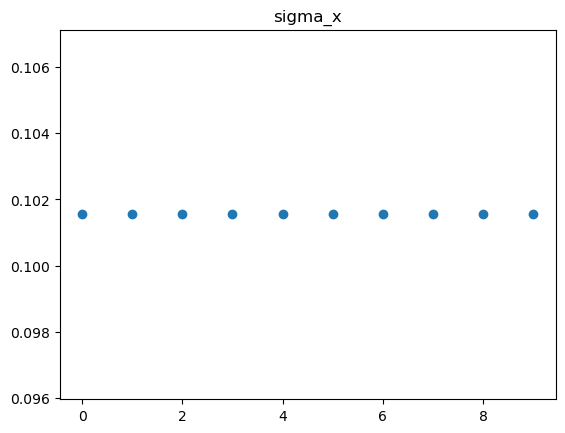

Parameter containing:
tensor(-0.8764, device='cuda:0', requires_grad=True) d


In [6]:
# # for name, prm in model.named_parameters():
# #     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')
# print('sigma_x', model.sigma_x)
# print('d', model.d)
print((model.C @ model.W).sum(axis=-1))
# print(torch.diag(model.Q[0]))
# print(torch.diag(model.Sigma0[0]))

# print(torch.linalg.eigvals(model.A))

# # print(model.lik.total_count)

plt.imshow(model.W[0].detach().cpu().numpy())
plt.colorbar()
plt.title('W')
plt.show()

plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow(model.C[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('C')
plt.show()

plt.plot(model.sigma_x.detach().cpu().numpy(), 'o')
plt.title('sigma_x')
plt.show()

print(model.d, 'd')
# print(model.lik.sigma, 'sigma')

step 0 LL -0.7903840762867647
step 1 LL -1.7316669730392158
step 2 LL -0.824645756740196
step 3 LL -0.786610715379902
step 4 LL -0.8178753829656863
step 5 LL -0.7896022518382353
step 6 LL -0.7909504442401961
step 7 LL -0.7946626072303922
step 8 LL -0.7866284083946078
step 9 LL -0.7805045955882353
step 10 LL -0.783387752757353
step 11 LL -0.7817091375612745
step 12 LL -0.7777130055147059
step 13 LL -0.7778415287990196
step 14 LL -0.7768035768995099
step 15 LL -0.7762795649509804
step 16 LL -0.7752895603553922
step 17 LL -0.7743302313112745
step 18 LL -0.7715834865196078
step 19 LL -0.7711002604166667
step 20 LL -0.772525390625
step 21 LL -0.7711190257352941
step 22 LL -0.7689083946078431
step 23 LL -0.7677784926470588
step 24 LL -0.769215762867647
step 25 LL -0.7693567708333333
step 26 LL -0.7672329197303922
step 27 LL -0.7663134574142156
step 28 LL -0.7665370710784314
step 29 LL -0.7674367340686274
step 30 LL -0.7667601485906863
step 31 LL -0.7651417738970588
step 32 LL -0.764967409620

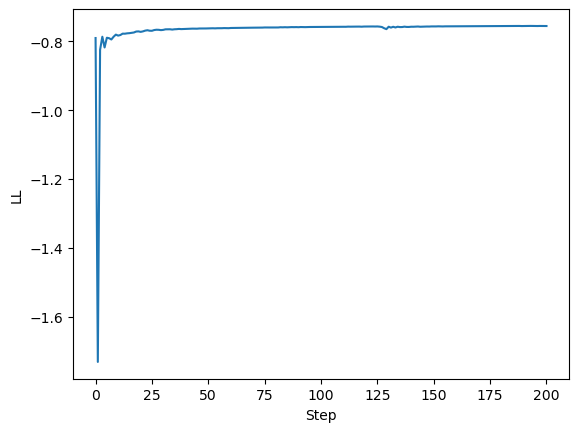

In [7]:
model.freeze_params()
class MyRNNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = MyRNNModel(model.N, 100, model.x_dim)

rec_model = RecognitionModel(model, rnn=True, neural_net=neural_net)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-3, 'max_steps': 201, 'n_mc_x': 25, 'n_mc_z': 100, 'batch_mc_z': 50}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

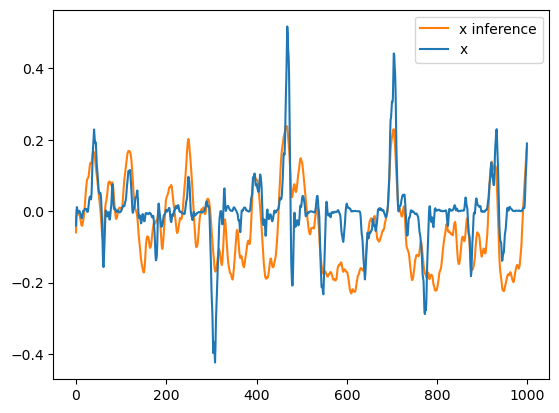

-0.3535686884879501
0.38721136825821023


In [8]:

z = rec_model.test_z(rec_model.gen_model.Y)

# Y_test = Y[..., train_len:]
# z = rec_model.test_z(Tensor(Y_test).to(device))

z = z.detach().cpu().numpy()

z = z.reshape(1,-1,1000)
W = np.load('params/W' + suffix + '.npy')
z = W @ z

train_len = 1000
# _vels = vels[train_len:]
_vels = vels[:train_len]

plt.plot(z[0,0,:], label = 'x inference', color = 'C1')
# plt.plot(z[0,1,:], label = 'y inference', color = 'C1')
plt.plot(_vels[:, 0], label = 'x', color = 'C0')
# plt.plot(_vels[:, 1], label = 'y', color = 'C0')
plt.legend()
plt.show()

# print R^2 for x and y decoding using sklearn
print(r2_score(_vels[:, 0], z[0,0,:]))
print(r2_score(_vels[:, 1], z[0,1,:]))